In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data/', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data/', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# 1 color channel, 6 filters (output channels, arbitrary), 3x3 kernel, stride=1
conv1 = nn.Conv2d(1,6,3,1) # original img ---> 6 filters ---> pooling ---> conv2

# 6 input filters from conv1, 16 filters (arbitrary), 3x3 kernel, stride=1
conv2 = nn.Conv2d(6,16,3,1)

In [9]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
# (add dimension to batch size (1), 1, 28, 28)
x = X_train.view(1, 1, 28, 28) # conver to ----> 4D batch (batch of 1 image)

In [11]:
x = F.relu(conv1(x))

In [12]:
x.shape # (1 image, 6 filters, losing border info (28->26), same->26) because no paddings are added

torch.Size([1, 6, 26, 26])

In [13]:
x = F.max_pool2d(x,2,2) # (data, 2x2 kernel, stride=2)

In [14]:
x.shape # reduce the size by 2 (because of 2x2 kernel and stride=2)

torch.Size([1, 6, 13, 13])

In [15]:
x = F.relu(conv2(x))

In [16]:
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
x = F.max_pool2d(x,2,2)

In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
((28-2)/2-2)/2 # how to get 5

5.5

In [20]:
x.view(-1,16*5*5).shape # keep first dimension, 16*5*5 to flatten

torch.Size([1, 400])

In [21]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [22]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
for param in model.parameters():
    print(param.numel())

# total = 60074

54
6
864
16
48000
120
10080
84
840
10


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
import time
start_time = time.time()

# variables (trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train) # not flatten (no longer needed cuz 2d data is required for conv2d)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() # true = 1 / false = 0
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f"epoch: {i} batch: {b} loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    # test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f"training took {total/60} minutes")

epoch: 0 batch: 600 loss: 0.042550645768642426
epoch: 0 batch: 1200 loss: 0.0760595053434372
epoch: 0 batch: 1800 loss: 0.3099583685398102
epoch: 0 batch: 2400 loss: 0.02055153250694275
epoch: 0 batch: 3000 loss: 0.007200016640126705
epoch: 0 batch: 3600 loss: 0.002412100089713931
epoch: 0 batch: 4200 loss: 0.5767076015472412
epoch: 0 batch: 4800 loss: 0.06680990010499954
epoch: 0 batch: 5400 loss: 0.00852256827056408
epoch: 0 batch: 6000 loss: 0.061696767807006836
epoch: 1 batch: 600 loss: 0.021697062999010086
epoch: 1 batch: 1200 loss: 0.04175395518541336
epoch: 1 batch: 1800 loss: 0.003502133535221219
epoch: 1 batch: 2400 loss: 0.02740946039557457
epoch: 1 batch: 3000 loss: 0.3473083972930908
epoch: 1 batch: 3600 loss: 0.001055808155797422
epoch: 1 batch: 4200 loss: 0.0015334103954955935
epoch: 1 batch: 4800 loss: 0.0008102000574581325
epoch: 1 batch: 5400 loss: 0.006761348806321621
epoch: 1 batch: 6000 loss: 0.014358989894390106
epoch: 2 batch: 600 loss: 0.0011277158046141267
epoch

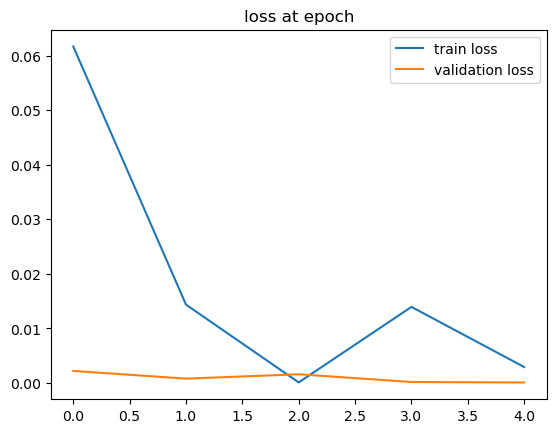

In [28]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='validation loss')
plt.title('loss at epoch')
plt.legend()

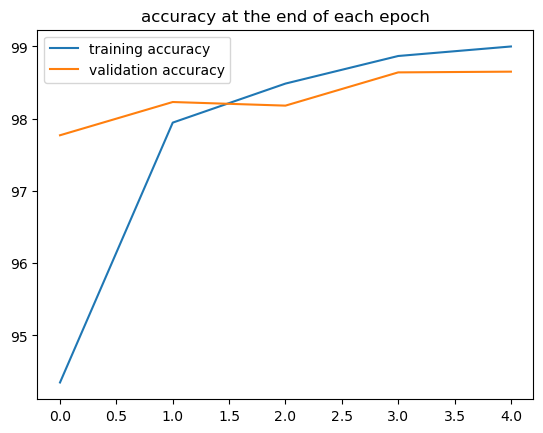

In [30]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('accuracy at the end of each epoch')
plt.legend()

In [31]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [33]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [34]:
correct.item()/len(test_data)

0.9865

In [36]:
# print a raw values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 969    0    0    0    0    2    3    0    3    0]
 [   0 1134    0    0    0    1    3    5    0    1]
 [   4    0 1027    4    1    0    1    6    4    2]
 [   0    1    0 1000    0    8    0    0    1    1]
 [   0    0    1    0  975    0    1    2    2   12]
 [   0    0    0    3    0  871    2    0    0    4]
 [   5    0    0    0    4    3  945    0    1    1]
 [   1    0    4    1    0    1    0 1012    0    8]
 [   1    0    0    1    0    2    3    1  963   11]
 [   0    0    0    1    2    4    0    2    0  969]]


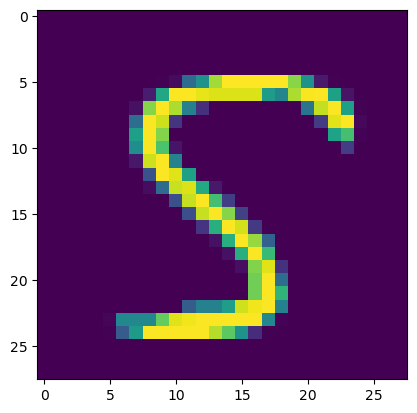

In [41]:
plt.imshow(test_data[333][0].reshape(28,28))

In [42]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[333][0].view(1,1,28,28))

In [43]:
new_prediction.argmax()

tensor(5)